# ALZHEIMER'S PREDICTION

IMPORT THE LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.xception import Xception, preprocess_input

### CREATING AN INSTANCE OF ImageDataGenerator

ImageDataGenerator is a class in the tensorflow.keras.preprocessing.image module that generates batches of augmented image data in real-time during model training.

In [2]:
IMG_SIZE = 180
IMAGE_SIZE=[180,180]
DIM =(IMG_SIZE,IMG_SIZE)
ZOOM=[0.99,1.01]
BRIGHT_RANGE=[0.8,1.2]
HORZ_FLIP = True
FILL_MODE='constant'
DATA_FORMAT='channels_last'

work_dir='/Users/jagger/Downloads/Data'
work_dr=ImageDataGenerator(rescale=1./255,
                           brightness_range=BRIGHT_RANGE,
                           zoom_range=ZOOM,
                           data_format=DATA_FORMAT,
                           fill_mode=FILL_MODE,
                           horizontal_flip=HORZ_FLIP
                          )

In [3]:
data_gen = work_dr.flow_from_directory(directory=work_dir,
                                       target_size=DIM,
                                       batch_size=6500,
                                       shuffle=False
                                      )

Found 86437 images belonging to 4 classes.


In [4]:
train_data,train_labels=data_gen.next()

In [5]:
print(train_data.shape,train_labels.shape)

(6500, 180, 180, 3) (6500, 4)


'''from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=42)

train_data,train_labels=sm.fit_resample(train_data.reshape(-1,IMG_SIZE*IMG_SIZE*3),train_labels)

train_data=train_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
print(train_data.shape,train_labels.shape)
'''

### SPLITTING TEST AND TRAIN DATA

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(train_data,train_labels,test_size=0.2,random_state=42)
train_data,val_data,train_labels,val_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)

### BUILDING THE MODEL

A simple feature extractor is used to freeze all the five convolution blocks to make sure their weights don’t get updated after each epoch as we train our own model.

In [7]:
xcep_model = Xception(input_shape=IMAGE_SIZE+[3], weights='imagenet',include_top=False)
for layer in xcep_model.layers:
    layer.trainable=False

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D, Dropout

custom_inception_model=Sequential([
    xcep_model,
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64,activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(4,activation='softmax')
],name='inception_cnn_model')

In [9]:
custom_inception_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 6, 6, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

### TRAIN THE MODEL

In [11]:
history=custom_inception_model.fit(train_data,train_labels,epochs=30,batch_size=10,verbose=1,validation_data=(test_data,test_labels))

Epoch 1/30
416/416 [==============================] - 299s 716ms/step - loss: 1.0544 - accuracy: 0.5947 - val_loss: 0.5839 - val_accuracy: 0.8062
Epoch 2/30
416/416 [==============================] - 271s 651ms/step - loss: 0.6872 - accuracy: 0.7538 - val_loss: 0.4941 - val_accuracy: 0.8377
Epoch 3/30
416/416 [==============================] - 272s 654ms/step - loss: 0.5959 - accuracy: 0.7812 - val_loss: 0.4112 - val_accuracy: 0.8577
Epoch 4/30
416/416 [==============================] - 239s 576ms/step - loss: 0.5359 - accuracy: 0.8046 - val_loss: 0.3656 - val_accuracy: 0.8762
Epoch 5/30
416/416 [==============================] - 232s 557ms/step - loss: 0.4967 - accuracy: 0.8070 - val_loss: 0.3032 - val_accuracy: 0.8869
Epoch 6/30
416/416 [==============================] - 233s 561ms/step - loss: 0.4657 - accuracy: 0.8240 - val_loss: 0.3232 - val_accuracy: 0.8777
Epoch 7/30
416/416 [==============================] - 258s 621ms/step - loss: 0.4101 - accuracy: 0.8416 - val_loss: 0.2219 -

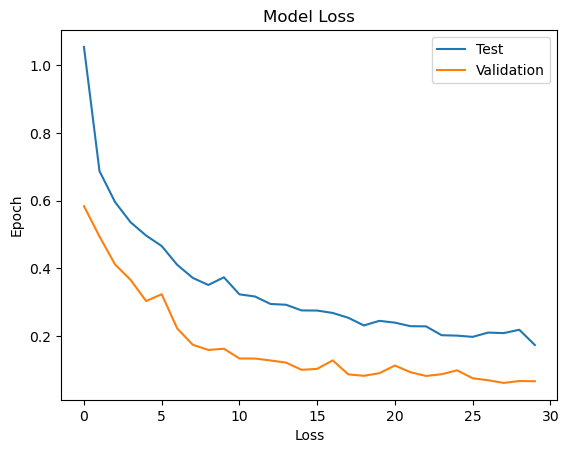

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend(['Test','Validation'],loc='upper right')
plt.show()

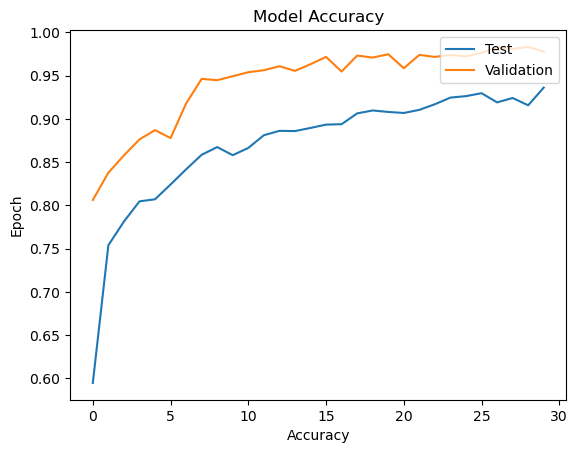

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epoch')
plt.legend(['Test','Validation'],loc='upper right')
plt.show()

In [16]:
custom_inception_model.save('adp.h5')

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import tensorflow as tf

In [4]:
model=load_model('/Users/jagger/Documents/EXTERNSHIP PROJECT/TRAINING/adp.h5')

### PRE-PROCESS THE IMAGE

In [5]:
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(180,180,3))  
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

In [7]:
categories = sorted(os.listdir('/Users/jagger/Documents/EXTERNSHIP PROJECT/DATASET/Data'))

In [8]:
print("Categories: ",categories)

Categories:  ['.DS_Store', 'Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


### FUNCTION TO PREDICT IMAGE 

In [9]:
def predict_category(image_path):
    processed_img = preprocess_image(image_path)
    predictions = model.predict(processed_img)
    category_index = np.argmax(predictions, axis=1)[0]
    categories = ['Mild Dementia','Moderate Dementia','Non Demented','Very mild Dementia']
    predicted_category = categories[category_index]
    return predicted_category

In [10]:
input_image_path = '/Users/jagger/Documents/EXTERNSHIP PROJECT/DATASET/Data/Mild Dementia/OAS1_0035_MR1_mpr-2_108.jpg'

In [11]:
predicted_category = predict_category(input_image_path)

1/1 [==============================] - 1s 518ms/step


In [12]:
print('Predicted Category:', predicted_category)

Predicted Category: Mild Dementia
